In [1]:
%cd /home/azureuser/localfiles

/home/azureuser/localfiles


In [2]:
!wget --no-check-certificate http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/birds.zip

--2022-02-21 18:25:27--  http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/birds.zip
Resolving homepages.cs.ncl.ac.uk (homepages.cs.ncl.ac.uk)... 128.240.212.24
Connecting to homepages.cs.ncl.ac.uk (homepages.cs.ncl.ac.uk)|128.240.212.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658039182 (1.5G) [application/zip]
Saving to: ‘birds.zip’

birds.zip           100%[===================>]   1.54G  8.25MB/s    in 3m 37s  

2022-02-21 18:29:04 (7.30 MB/s) - ‘birds.zip’ saved [1658039182/1658039182]



In [2]:
!wget --no-check-certificate http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/Test_Images.zip

--2022-03-11 11:07:54--  http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/Test_Images.zip
Resolving homepages.cs.ncl.ac.uk (homepages.cs.ncl.ac.uk)... 128.240.212.24
Connecting to homepages.cs.ncl.ac.uk (homepages.cs.ncl.ac.uk)|128.240.212.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708674 (692K) [application/zip]
Saving to: ‘Test_Images.zip’

Test_Images.zip     100%[===================>] 692.06K  --.-KB/s    in 0.1s    

2022-03-11 11:07:54 (4.54 MB/s) - ‘Test_Images.zip’ saved [708674/708674]



In [3]:
import zipfile
zip_file = '/home/azureuser/localfiles/birds.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/home/azureuser/localfiles/')
zip_ref.close()

In [3]:
import zipfile
zip_file = '/home/azureuser/localfiles/Test_Images.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/home/azureuser/localfiles/')
zip_ref.close()

In [2]:
import os
from os.path import join
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
workingdir = os.path.abspath('')
trainingdirectory = os.path.join(workingdir + '/train/')
validationdirectory = os.path.join(workingdir + '/valid/')

In [4]:
trainingset = tf.keras.preprocessing.image_dataset_from_directory(trainingdirectory, image_size = (100, 100), 
                label_mode = 'categorical', shuffle = True)
validationset = tf.keras.preprocessing.image_dataset_from_directory(validationdirectory, image_size = (100, 100), 
                label_mode = 'categorical', shuffle = True)

Found 35215 files belonging to 250 classes.
Found 1250 files belonging to 250 classes.


In [5]:
trainingsetpref = trainingset.prefetch(buffer_size = tf.data.AUTOTUNE)
validationsetpref = validationset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [6]:
vgg16model = VGG16(weights = "imagenet", include_top = False, input_shape = (100, 100, 3))
vgg16model.trainable = True

In [7]:
cnnmodel = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    vgg16model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation = 'relu'),
    tf.keras.layers.Dense(4096, activation = 'relu'),
    tf.keras.layers.Dense(250, activation = 'softmax')
])

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
cnnmodel.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy', 
                tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
checkpoint = ModelCheckpoint(filepath="./models/cnnmodel1.h5", verbose=2, save_best_only=True)
earlystopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10,  restore_best_weights = True)

In [10]:
fitdata = cnnmodel.fit(trainingset, steps_per_epoch = len(trainingset), 
            validation_data = validationset, validation_steps = len(validationset), epochs = 1, 
            callbacks=[checkpoint, earlystopping])

1101/1101 [==============================] - ETA: 0s - loss: 5.3756 - accuracy: 0.0193 - precision: 0.3007 - recall: 0.0012
Epoch 00001: val_loss improved from inf to 4.49427, saving model to ./models/cnnmodel1.h5
1101/1101 [==============================] - 189s 167ms/step - loss: 5.3756 - accuracy: 0.0193 - precision: 0.3007 - recall: 0.0012 - val_loss: 4.4943 - val_accuracy: 0.0888 - val_precision: 0.5366 - val_recall: 0.0176


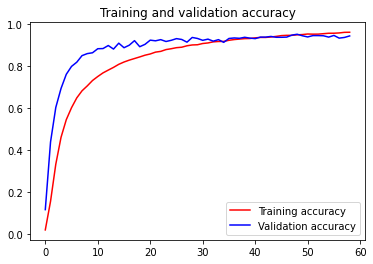

<Figure size 432x288 with 0 Axes>

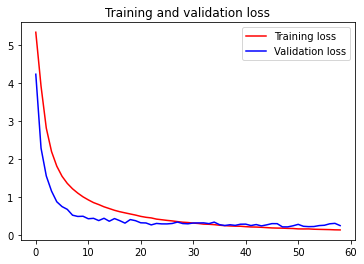

<Figure size 432x288 with 0 Axes>

In [21]:
accuracy = fitdata.history['accuracy']
validation_accuracy = fitdata.history['val_accuracy']
loss = fitdata.history['loss']
validation_loss = fitdata.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, validation_loss, 'blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [8]:
testparentdirectory = os.path.join(workingdir + '/test/')
testdata = tf.keras.preprocessing.image_dataset_from_directory(testparentdirectory, image_size = (100,100), 
            label_mode = 'categorical')
testsetpref = testdata.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1250 files belonging to 250 classes.


In [9]:
cnnmodel = tf.keras.models.load_model('./models/cnnmodel.h5')

In [10]:
testevaluate = cnnmodel.evaluate(testsetpref)

40/40 [==============================] - 5s 51ms/step - loss: 0.1288 - accuracy: 0.9680 - precision_1: 0.9740 - recall_1: 0.9608


In [11]:
testdatagen = ImageDataGenerator(rescale=1. / 255)
testgenerator = testdatagen.flow_from_directory(testparentdirectory,
                target_size=(100, 100), class_mode='categorical')

Found 1250 images belonging to 250 classes.


In [12]:
predictions = cnnmodel.predict(testgenerator, verbose = 1)

40/40 [==============================] - 2s 48ms/step


In [25]:
ypred = np.argmax(predictions, axis=1)

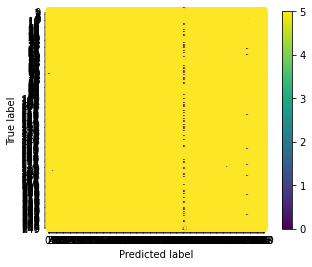

In [26]:
cm = confusion_matrix(testgenerator.classes, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [27]:
testparentdirectory = os.path.join(workingdir)
testdataimage = ImageDataGenerator(rescale = 1./255)
testdata = testdataimage.flow_from_directory(testparentdirectory, classes=['Testbird'], target_size = (100,100))
testoutput = cnnmodel.predict(testdata, verbose = 1)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 403ms/step


In [28]:
ypredtest = np.argmax(testoutput, axis=1)

In [29]:
ypredtest[0]

240

In [30]:
title = testgenerator.class_indices
title = dict((v,k) for k,v in title.items())
classes = [title[k] for k in ypredtest]

In [31]:
classes

['WHIMBREL']